# News Sentiment on Stock Market Prediction

#### Tianyi Hu
#### th2761@columbia.edu

# Import Packages

In [271]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from nltk.sentiment.vader import SentimentIntensityAnalyzer # VADER https://github.com/cjhutto/vaderSentiment
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
import wordcloud
import re
import pysentiment as ps
import datetime as dt
from datetime import datetime
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter
import string
import nltk
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC, LinearSVC

In [2]:
words = stopwords.words("english")
stemmer = PorterStemmer()
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/tianyihu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tianyihu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Read Two Datasets (News headlines & DJIA Daily Price)

In [3]:
df=pd.read_csv("News_Data.csv",encoding = 'unicode_escape')
dj_df = pd.read_csv("DJIA_price.csv")
dj_df = dj_df.sort_values(by = 'Date', ascending=True)

In [4]:
dj_df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,11501.849609,11522.009766,11305.690430,11357.509766,11357.509766,169750000
1,2000-01-04,11349.750000,11350.059570,10986.450195,10997.929688,10997.929688,178420000
2,2000-01-05,10989.370117,11215.099609,10938.669922,11122.650391,11122.650391,203190000
3,2000-01-06,11113.370117,11313.450195,11098.450195,11253.259766,11253.259766,176550000
4,2000-01-07,11247.059570,11528.139648,11239.919922,11522.559570,11522.559570,184900000


In [5]:
df.head(3)

,Date,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,Derby raise a glass to Strupar's debut double,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,Hopkins 'furious' at Foster's lack of Hannibal...,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,McGrath puts India out of their misery,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links


# Merge Two Datasets; Add New Column (Label)
### Label: 0 (decrease);1(increase or keep same)

In [6]:
dj_df['change']=dj_df['Adj Close']-dj_df['Adj Close'].shift(1)
dj_df['change'][0]='-139.61'
full_data=pd.merge(df,dj_df,how='inner',on=None,left_on=None,right_on=None,left_index=False,right_index=False,sort=True,suffixes=('_x','_y'),copy=True,indicator=False)
full_data["Label"] = ["1" if change >=0 else "0" 
                            for change in full_data["change"].apply(int)]
df=full_data[['Date','Label',"Top1","Top2","Top3","Top4","Top5","Top6","Top7","Top8","Top9","Top10","Top11","Top12","Top13","Top14","Top15","Top16","Top17","Top18","Top19","Top20","Top21","Top22","Top23","Top24","Top25"]]
df.head(3)

/Users/tianyihu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2000-01-03,0,A 'hindrance to operations': extracts from the...,Scorecard,Hughes' instant hit buoys Blues,Jack gets his skates on at ice-cold Alex,Chaos as Maracana builds up for United,Depleted Leicester prevail as Elliott spoils E...,Hungry Spurs sense rich pickings,Gunners so wide of an easy target,...,Flintoff injury piles on woe for England,Hunters threaten Jospin with new battle of the...,Kohl's successor drawn into scandal,The difference between men and women,"Sara Denver, nurse turned solicitor",Diana's landmine crusade put Tories in a panic,Yeltsin's resignation caught opposition flat-f...,Russian roulette,Sold out,Recovering a title
1,2000-01-04,0,Scorecard,The best lake scene,Leader: German sleaze inquiry,"Cheerio, boyo",The main recommendations,Has Cubie killed fees?,Has Cubie killed fees?,Has Cubie killed fees?,...,On the critical list,The timing of their lives,Dear doctor,Irish court halts IRA man's extradition to Nor...,Burundi peace initiative fades after rebels re...,PE points the way forward to the ECB,Campaigners keep up pressure on Nazi war crime...,Jane Ratcliffe,Yet more things you wouldn't know without the ...,Millennium bug fails to bite
2,2000-01-05,1,Coventry caught on counter by Flo,United's rivals on the road to Rio,Thatcher issues defence before trial by video,Police help Smith lay down the law at Everton,Tale of Trautmann bears two more retellings,England on the rack,Pakistan retaliate with call for video of Walsh,Cullinan continues his Cape monopoly,...,South Melbourne (Australia),Necaxa (Mexico),Real Madrid (Spain),Raja Casablanca (Morocco),Corinthians (Brazil),Tony's pet project,Al Nassr (Saudi Arabia),Ideal Holmes show,Pinochet leaves hospital after tests,Useful links


# Raw Data Description

In [7]:
dj_df=dj_df.set_index('Date')

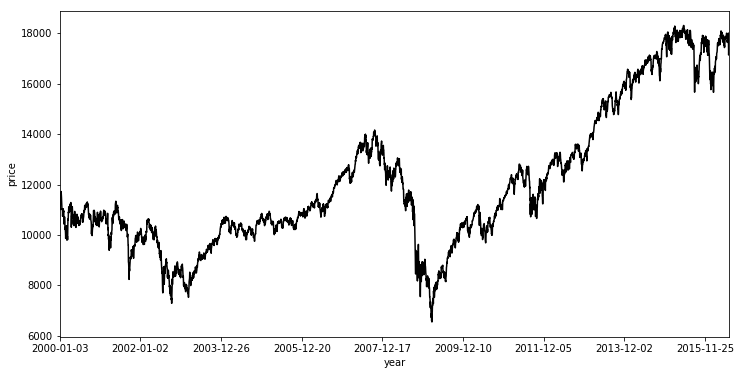

In [8]:
figsize = 12,6
dj_df['Adj Close'].plot(figsize=figsize,color = 'black')
plt.xlabel('year')
plt.ylabel('price')
plt.show()

# Text Preprocessing

In [150]:
# Create a new column with the Top N news joined.
columns = ['Top' + str(i+1) for i in range(20)]
df['Joined News'] = df[columns].apply(lambda x: ' '.join(x.astype(str)), axis=1)
# Create a new dataframe with only Date and joined columns
df1 = df[['Date', 'Label','Joined News']].copy()
df1.head()

/Users/tianyihu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Label,Joined News
0,2000-01-03,0,A 'hindrance to operations': extracts from the...
1,2000-01-04,0,Scorecard The best lake scene Leader: German s...
2,2000-01-05,1,Coventry caught on counter by Flo United's riv...
3,2000-01-06,1,Pilgrim knows how to progress Thatcher facing ...
4,2000-01-07,1,Hitches and Horlocks Beckham off but United su...


In [151]:
#Lower Case
df1['Joined News'] = df1['Joined News'] .apply(lambda x: " ".join(x.lower() for x in x.split()))
#Remove Punctuation
df1['Joined News'] = df1['Joined News'] .str.replace('[^\w\s]','')
#Remove Stopwords
stop = stopwords.words('english')
df1['cleaned'] = df1['Joined News'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
#Tokenize
df1['review_tokenized'] = df1.cleaned.apply(lambda x: word_tokenize(x))
#Lemmatization
lemmatizer = WordNetLemmatizer()
df1['review_lemmatized'] = df1.review_tokenized.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [152]:
df1.head()

,Date,Label,Joined News,cleaned,review_tokenized,review_lemmatized
0,2000-01-03,0,a hindrance to operations extracts from the le...,hindrance operations extracts leaked reports s...,"[hindrance, operations, extracts, leaked, repo...","[hindrance, operation, extract, leaked, report..."
1,2000-01-04,0,scorecard the best lake scene leader german sl...,scorecard best lake scene leader german sleaze...,"[scorecard, best, lake, scene, leader, german,...","[scorecard, best, lake, scene, leader, german,..."
2,2000-01-05,1,coventry caught on counter by flo uniteds riva...,coventry caught counter flo uniteds rivals roa...,"[coventry, caught, counter, flo, uniteds, riva...","[coventry, caught, counter, flo, uniteds, riva..."
3,2000-01-06,1,pilgrim knows how to progress thatcher facing ...,pilgrim knows progress thatcher facing ban mci...,"[pilgrim, knows, progress, thatcher, facing, b...","[pilgrim, know, progress, thatcher, facing, ba..."
4,2000-01-07,1,hitches and horlocks beckham off but united su...,hitches horlocks beckham united survive breast...,"[hitches, horlocks, beckham, united, survive, ...","[hitch, horlocks, beckham, united, survive, br..."


# Create WordCloud

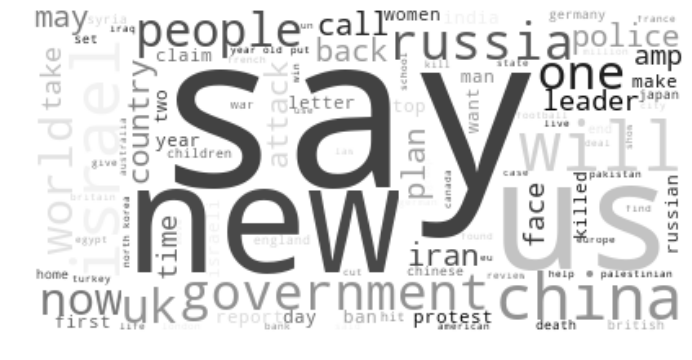

In [348]:
#Create Wordcloud
news_combined = ''
news_lemm=''
for row in range(0,len(df.index)):
    news_combined+=' '.join(str(x).lower().strip() for x in df.iloc[row,2:27] if x  not in stop)
    
vectorizer = CountVectorizer()
news_vect = vectorizer.build_tokenizer()(news_combined)
lemmatizer = WordNetLemmatizer()
news_lemm = ' '.join([lemmatizer.lemmatize(w) for w in news_vect])

word_counts = pd.DataFrame([[x,news_lemm.count(x)] for x in set(news_lemm)], columns = ['Word', 'Count'])
# colormap: https://matplotlib.org/examples/color/colormaps_reference.html
# To present in my thesis paper, I chose colormap='gist_gray'
wordcloud = WordCloud(background_color="white",max_words=100, colormap='gist_gray').generate(news_combined)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

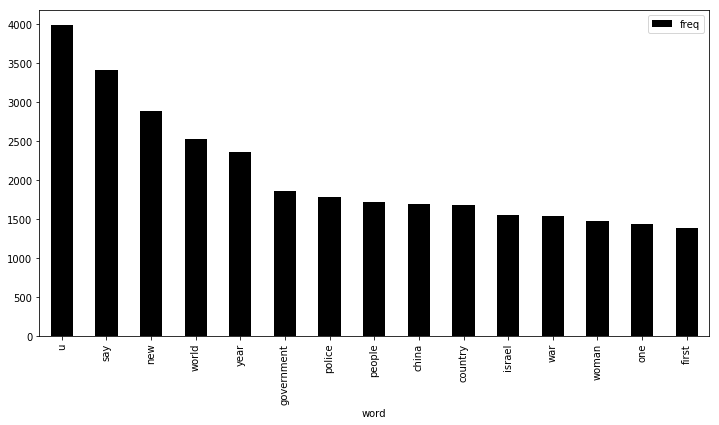

In [346]:
news_list =df1['review_lemmatized'].tolist()
news_list = [item for sublist in news_list for item in sublist]
word_counter = Counter(news_list)
most_common_words = word_counter.most_common()[:15]
most_common_words = pd.DataFrame(most_common_words)
most_common_words.columns = ['word', 'freq']
most_common_words.sort_values(by='freq',ascending=False).plot(x='word', kind='bar', color='black',figsize=figsize)

# VADER analysis

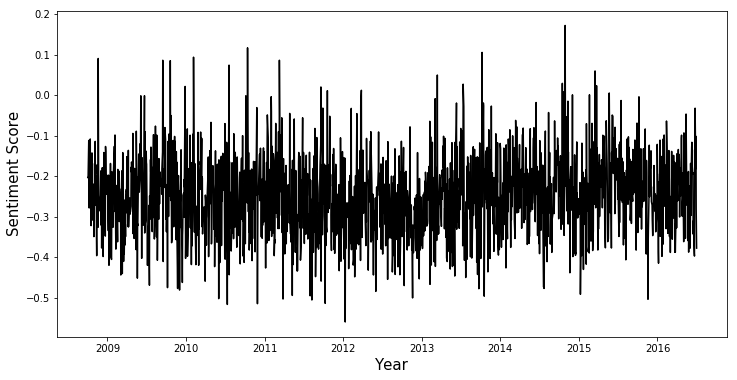

In [33]:
vscores = pd.DataFrame(index = df.Date, columns = ['Compound', 'Positive', 'Negative', "Neutral"])
analyzer = SentimentIntensityAnalyzer() # Use the VADER Sentiment Analyzer
for j in range(0,df.shape[0]):    
    tmp_neu = 0
    tmp_neg = 0
    tmp_pos = 0
    tmp_comp = 0
    for i in range(2,df.shape[1]):
        text = df.iloc[j,i]
        if(str(text) == "nan"):
            tmp_comp +=  0
            tmp_neg += 0
            tmp_neu += 0
            tmp_pos += 0
        else:
            vs = analyzer.polarity_scores(df.iloc[j,i])
            tmp_comp +=  vs['compound']
            tmp_neg += vs['neg']
            tmp_neu += vs['neu']
            tmp_pos += vs['pos']
    
    vscores.iloc[j,] = [tmp_comp, tmp_pos, tmp_neg, tmp_neu]
vscores['Score']=vscores['Compound']/25
vscores.index = pd.to_datetime(vscores.index)
vscores_part=vscores[2150:]
plt.figure(figsize=(12,6)) 
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.xlabel('Year',color='black',fontsize='15')
plt.ylabel('Sentiment Score',color='black',fontsize='15')
plt.plot(vscores_part.Score,color='black')
plt.show()

In [56]:
vscores_part.mean()

Compound    -6.208127
Positive     1.536425
Negative     4.056621
Neutral     20.403361
Score       -0.248325
dtype: float64

In [65]:
#Want to find the peak value in 2014
vscores_part.sort_values('Score', ascending=False).head(1)

,index,Date,Compound,Positive,Negative,Neutral,Score
1529,1529,2014-10-29,4.3002,3.3,1.532,21.169,0.172008


In [112]:
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for word in subset:
    if (sid.polarity_scores(word)['compound']) >= 0.5:
        pos_word_list.append(word)
    elif (sid.polarity_scores(word)['compound']) <= -0.5:
        neg_word_list.append(word)
    else:
        neu_word_list.append(word)                

print('Positive :',pos_word_list)         
print('Negative :',neg_word_list) 

Positive : ['rich', 'supreme', 'justice', 'honour', 'win', 'great', 'free']
Negative : ['threat']


# LM Analysis 

In [41]:
lmtokdata = {}
lm = ps.LM()
lm_tdf = pd.DataFrame (lmtokdata,
                    columns = ['LMTokens'])
lm_tdf['LMTokens'] = df1.apply(lambda row: lm.tokenize(row['cleaned']), axis=1)

In [42]:
##Sorting Data and Performing sentiment analysis on tokenized data##
lmscoredata = {}
lm_calc_df = pd.DataFrame (lmscoredata,
               columns = ['LMSentiment'])
lm_calc_df['LMSentiment'] = lm_tdf.apply(lambda row: lm.get_score(row['LMTokens']), axis = 1)

In [45]:
lm_scores = lm_calc_df['LMSentiment'].apply(pd.Series)
lm_scores.rename(columns={'Negative': 'LMNeg', 'Polarity': 'LMPol', 'Positive':'LMPos', 'Subjectivity':'LMSub'}, inplace=True)
lm_scores['Date']=df1['Date']
lm_scores_part=lm_scores[2150:]
lm_scores_part.mean()

LMPos     1.992824
LMNeg    15.860072
LMPol    -0.776902
LMSub     0.101411
dtype: float64

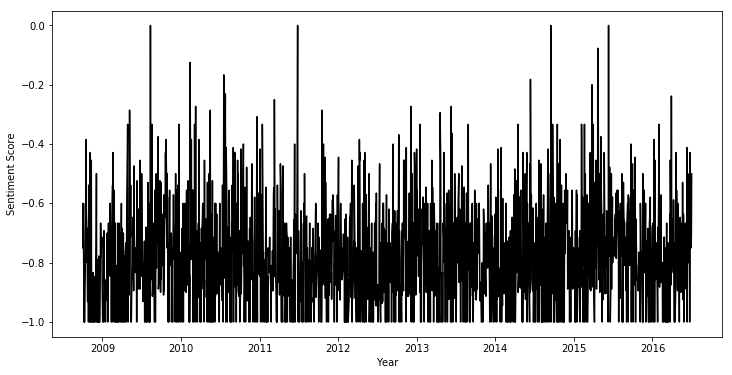

In [51]:
lm_scores_part.index = pd.to_datetime(lm_scores_part.Date)
plt.figure(figsize=(12,6)) 
plt.xticks(fontsize =10)
plt.yticks(fontsize =10)
plt.xlabel('Year',color='black',fontsize='10')
plt.ylabel('Sentiment Score',color='black',fontsize='10')
plt.plot(lm_scores_part.LMPol,color='black')
plt.show()

# Machine Learning Models

# (1) Naive Bayes

### train/test split = 90/10

In [303]:
train = df1[df1['Date'] < '20150101']
test = df1[df1['Date'] > '20141231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = GaussianNB()
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result1=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result1=pd.DataFrame(result1)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,150,34
1,32,162


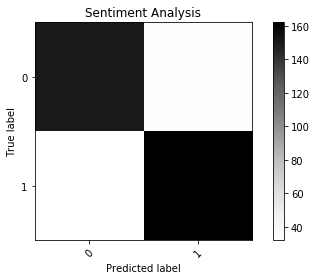

In [304]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result1, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [305]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3975, 52140)
             precision    recall  f1-score   support

          0       0.82      0.82      0.82       184
          1       0.83      0.84      0.83       194

avg / total       0.83      0.83      0.83       378

0.8253968253968254


### train/test split=80/20

In [306]:
train = df1[df1['Date'] < '20140101']
test = df1[df1['Date'] > '20131231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = GaussianNB()
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result2=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result2=pd.DataFrame(result2)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,194,101
1,80,255


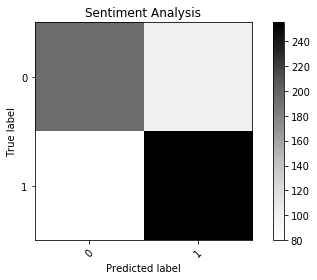

In [307]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result2, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [308]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3723, 50084)
             precision    recall  f1-score   support

          0       0.71      0.66      0.68       295
          1       0.72      0.76      0.74       335

avg / total       0.71      0.71      0.71       630

0.7126984126984127


### train/test split=70/30

In [309]:
train = df1[df1['Date'] < '20130101']
test = df1[df1['Date'] > '20121231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = GaussianNB()
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result3=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result3=pd.DataFrame(result3)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,271,129
1,181,301


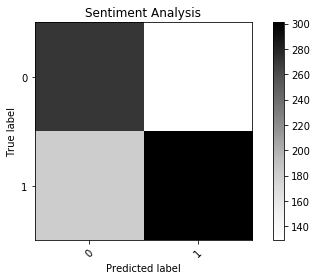

In [310]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result3, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [311]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3471, 47991)
             precision    recall  f1-score   support

          0       0.60      0.68      0.64       400
          1       0.70      0.62      0.66       482

avg / total       0.65      0.65      0.65       882

0.6485260770975056


# (2) Random Forest

### train/test split = 90/10

In [317]:
train = df1[df1['Date'] < '20150101']
test = df1[df1['Date'] > '20141231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = RandomForestClassifier(n_estimators=200, criterion='entropy',max_features='auto')
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result4=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result4=pd.DataFrame(result4)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,139,45
1,16,178


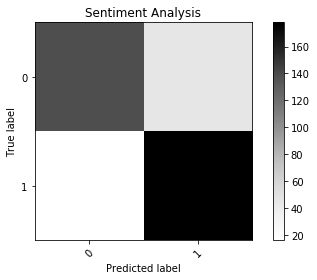

In [318]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result4, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [319]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3975, 52140)
             precision    recall  f1-score   support

          0       0.90      0.76      0.82       184
          1       0.80      0.92      0.85       194

avg / total       0.85      0.84      0.84       378

0.8386243386243386


### train/test split=80/20 

In [320]:
train = df1[df1['Date'] < '20140101']
test = df1[df1['Date'] > '20131231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = RandomForestClassifier(n_estimators=200, criterion='entropy',max_features='auto')
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result5=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result5=pd.DataFrame(result5)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,139,156
1,23,312


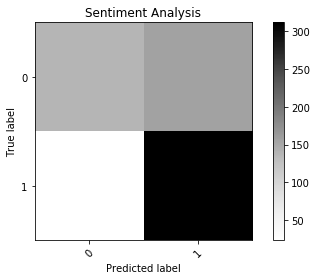

In [321]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result5, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [322]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3723, 50084)
             precision    recall  f1-score   support

          0       0.86      0.47      0.61       295
          1       0.67      0.93      0.78       335

avg / total       0.76      0.72      0.70       630

0.7158730158730159


### train/test split=70/30

In [323]:
train = df1[df1['Date'] < '20130101']
test = df1[df1['Date'] > '20121231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = RandomForestClassifier(n_estimators=200, criterion='entropy',max_features='auto')
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result6=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result6=pd.DataFrame(result6)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,149,251
1,43,439


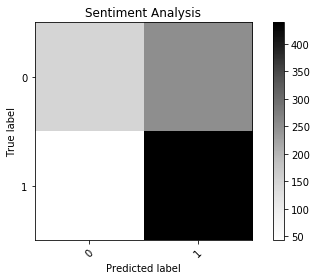

In [324]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result6, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [325]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3471, 47991)
             precision    recall  f1-score   support

          0       0.78      0.37      0.50       400
          1       0.64      0.91      0.75       482

avg / total       0.70      0.67      0.64       882

0.6666666666666666


# (3) SVM

### train/test=90/10

In [292]:
train = df1[df1['Date'] < '20150101']
test = df1[df1['Date'] > '20141231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = svm.LinearSVC(C=0.1, class_weight='balanced')
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result7=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result7=pd.DataFrame(result7)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,151,33
1,29,165


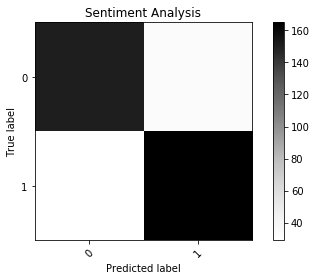

In [293]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result7, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [294]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3975, 52140)
             precision    recall  f1-score   support

          0       0.84      0.82      0.83       184
          1       0.83      0.85      0.84       194

avg / total       0.84      0.84      0.84       378

0.8359788359788359


### train/test=80/20

In [295]:
train = df1[df1['Date'] < '20140101']
test = df1[df1['Date'] > '20131231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = svm.LinearSVC(C=0.1, class_weight='balanced')
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result8=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result8=pd.DataFrame(result8)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,160,135
1,84,251


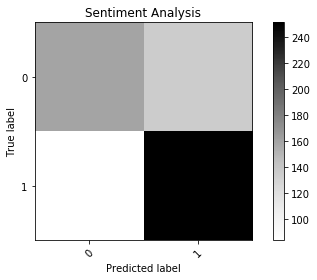

In [296]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result8, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [297]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3723, 50084)
             precision    recall  f1-score   support

          0       0.66      0.54      0.59       295
          1       0.65      0.75      0.70       335

avg / total       0.65      0.65      0.65       630

0.6523809523809524


### train/test=70/30

In [390]:
train = df1[df1['Date'] < '20130101']
test = df1[df1['Date'] > '20121231']
slicedData= train.iloc[:,3]
headlines = slicedData.tolist() 
slicedData= test.iloc[:,3]
testheadlines = slicedData.tolist() 
basicvectorizer = CountVectorizer(ngram_range=(1,1))
basictrain = basicvectorizer.fit_transform(headlines)
basicmodel = svm.LinearSVC(C=0.1, class_weight='balanced')
basicmodel = basicmodel.fit(basictrain.toarray(), train["Label"])
basictest = basicvectorizer.transform(testheadlines)
predictions = basicmodel.predict(basictest.toarray())
result9=pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])
result9=pd.DataFrame(result9)
pd.crosstab(test["Label"], predictions, rownames=["Actual"], colnames=["Predicted"])

Predicted,0,1
Actual,,
0,212,188
1,127,355


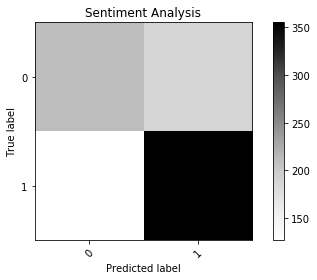

In [391]:
classes = ["0", "1"]
plt.figure()
plt.imshow(result9, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Sentiment Analysis")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [392]:
print(basictrain.shape)
print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(3471, 47991)
             precision    recall  f1-score   support

          0       0.63      0.53      0.57       400
          1       0.65      0.74      0.69       482

avg / total       0.64      0.64      0.64       882

0.6428571428571429


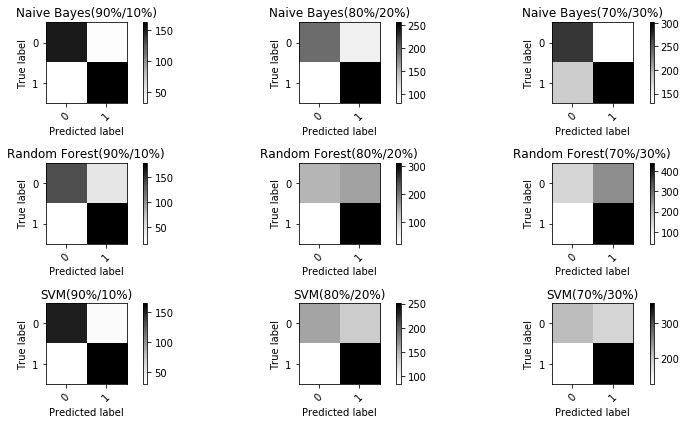

In [394]:
# Plot the above 9 pics together
plt.figure(figsize=figsize)
ax1 = plt.subplot(3,3,1)
ax2 = plt.subplot(3,3,2)
ax3 = plt.subplot(3,3,3)
ax4 = plt.subplot(3,3,4)
ax5 = plt.subplot(3,3,5)
ax6 = plt.subplot(3,3,6)
ax7 = plt.subplot(3,3,7)
ax8 = plt.subplot(3,3,8)
ax9 = plt.subplot(3,3,9)
plt.sca(ax1)
plt.imshow(result1, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Naive Bayes(90%/10%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.sca(ax2)
plt.imshow(result2, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Naive Bayes(80%/20%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.sca(ax3)
plt.imshow(result3, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Naive Bayes(70%/30%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.sca(ax4)
plt.imshow(result4, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Random Forest(90%/10%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.sca(ax5)
plt.imshow(result5, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Random Forest(80%/20%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.sca(ax6)
plt.imshow(result6, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("Random Forest(70%/30%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.sca(ax7)
plt.imshow(result7, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("SVM(90%/10%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.sca(ax8)
plt.imshow(result8, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("SVM(80%/20%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.sca(ax9)
plt.imshow(result9, interpolation='nearest', cmap=plt.cm.Greys)
plt.title("SVM(70%/30%)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

plt.show()